# Amazon Review Helpfulness Prediction

## Problem Statement

In this project, we will try to automatically predict the helpfulness of Amazon.com product reviews, specifically in
the case of home and kitchen products.

The inspiration behind this project is that the product we buy is mostly influenced by the review about the product. In most of the e-commerce platform, the most helpful reviews are displayed on the products front page.In order to differentiate reviews based on their helpfulness, Amazon has implemented an interface that allows customers to vote on whether a particular review has been helpful or unhelpful. The fraction of customers who have deemed the review helpful is displayed with the review, and  amazon uses these ratings to rank the reviews, displaying the most helpful rankings on the products front page. The drawback is that more recently written reviews are at a disadvantage since less people have voted on the helpfulness of the review. Because of this, reviews with few votes cannot be effectively ranked and will not gain visibility until they have accumulated adequate votes, which can take some time.

As a result, we would like to assess the helpfulness of reviews automatically, without having to wait for users to manually vote over the course of time. If we can do this, we would be able to give users the most relevant, helpful, and up to date reviews possible, without any delay in more helpful reviews being displayed. Moreover, such an automatic classification of reviews would be able to help in rooting out poorly written reviews lacking helpful information to other consumers.

For the problem statement, we will use the Home and Kitchen dataset which is having around 346,355 reviews. Dataset is available at JmCauley page: http://jmcauley.ucsd.edu/data/amazon/links.html

### Import and Initialization

In [1]:
# Importing the relevant dependencies
import numpy as np
import pandas as pd
import gzip
import math, time, random, datetime
import string
import os
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from collections import defaultdict
from gensim.models import Word2Vec

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
import pickle

In [2]:
# folder where input data and pickle data load present
data_folder = '../data/dataLoad/'
input_folder = '../data/raw/'

### Data Loading

In [3]:
# Loading the home and kitchen dataset which is downloaded in the /data path
input_data = 'reviews_Home_and_Kitchen_5.json.gz'
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i +=1
    return pd.DataFrame.from_dict(df, orient='index')

data = getDF(input_folder + input_data)   

In [4]:
data.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"


As mentioned in the jmcauley site, belaw are the description of the fields:
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3.
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)

### Data Preprocessing 

Before selecting features from the data, need to narrow down search to those reviews that had more than 10 total reviews. The ratio of people that find it helpful is more important. This effect can disappear at small ratings (e.g 1/2) so the reviews with less than 10 ratings have been eliminated. Beyond that we also limited our search to reviews for products had at least 10 reviews, because automated helpfulness classification itself is not necessary if the given product for which the reviews are being displayed has few reviews to begin with.

#### Data Filtering 

In [5]:
# Size of the data before filtering
data.shape

(551682, 9)

In [6]:
# Filter the products which has atleast 10 reviews
groupby_product = data.groupby('asin').size()
filter_reviews = data.groupby('asin').size().values >= 10
filter_asins = groupby_product[filter_reviews].index
data_filter = data.loc[data['asin'].isin(filter_asins), :]
data_filter.shape

(462551, 9)

In [7]:
# Filter the reviews having more than 10 helpful reviews
dataset = data_filter[data_filter['helpful'].apply(lambda x: x[1] > 10)]
dataset.shape

(27477, 9)

Now our data is reduced down to 86914 product reviews. Next is deriving the helpfulness target variable.The problem statement is the classification problem that needs to be mapped to discrete class, in our case its binary classification with 2 discrete class i.e; 1/0 which map to Helpful/Not Helpful class repectively. We use the sigmoid function in order to map predicted values to probability values. This sigmoid function then maps any real value into a probability value between 0 and 1.
The sigmoid function returns a probability value between 0 and 1. This probability value is then mapped to a discrete class which is either “0” or “1”. In order to map this probability value to a discrete class (pass/fail, yes/no, true/false), we select a threshold value. This threshold value is called Decision boundary. Above this threshold value, we will map the probability values into class 1 and below which we will map values into class 0.

Mathematically, it can be expressed as follows:-

                p ≥ 0.5 => class = 1

                p < 0.5 => class = 0 


Generally, the decision boundary is set to 0.5. So, if the probability value is 0.8 (> 0.5), we will map this observation to class 1. Similarly, if the probability value is 0.2 (< 0.5), we will map this observation to class 0.

We will also build custom features which will help in predicting the helpfulness further.

#### Deriving Helpfulness Target variable from features 

In [8]:
dataset['helpful_ratings'] = dataset['helpful'].apply(lambda x: x[0])
dataset['total_ratings'] = dataset['helpful'].apply(lambda x: x[1])

dataset.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_ratings,total_ratings
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013",26,27


In [9]:
dataset.describe()

,overall,unixReviewTime,helpful_ratings,total_ratings
count,27477.000000,2.747700e+04,27477.000000,27477.000000
mean,3.853769,1.261137e+09,47.941988,52.304982
std,1.447439,9.132063e+07,339.326083,344.390836
min,1.000000,9.572256e+08,0.000000,11.000000
25%,3.000000,1.201651e+09,12.000000,14.000000
50%,5.000000,1.282090e+09,19.000000,22.000000
75%,5.000000,1.331251e+09,38.000000,43.000000
max,5.000000,1.405642e+09,52176.000000,52861.000000


Lets checkout the extreme total ratings. It looks like an outlier.

In [10]:
dataset[dataset.helpful_ratings == dataset.helpful_ratings.max()]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_ratings,total_ratings
396128,A1TTA1UUGY4WY4,B0047E0EII,SW3K,"[52176, 52861]",For decades I have been trying to come up with...,5.0,"No more winning for you, Mr. Banana!",1299110400,"03 3, 2011",52176,52861


In [11]:
dataset = dataset.drop(dataset.index[dataset.helpful_ratings == dataset.helpful_ratings.max()])

In [12]:
dataset.describe()

,overall,unixReviewTime,helpful_ratings,total_ratings
count,27476.000000,2.747600e+04,27476.000000,27476.000000
mean,3.853727,1.261136e+09,46.044766,50.382989
std,1.447449,9.132200e+07,127.439043,130.782279
min,1.000000,9.572256e+08,0.000000,11.000000
25%,3.000000,1.201651e+09,12.000000,14.000000
50%,5.000000,1.282090e+09,19.000000,22.000000
75%,5.000000,1.331251e+09,38.000000,43.000000
max,5.000000,1.405642e+09,6128.000000,6174.000000


Lets check the count of reviews greater than 1000 and remove them if they are making the distribution a bit more skewed

In [13]:
dataset[dataset.total_ratings > 1000].count()

reviewerID         68
asin               68
reviewerName       68
helpful            68
reviewText         68
overall            68
summary            68
unixReviewTime     68
reviewTime         68
helpful_ratings    68
total_ratings      68
dtype: int64

The count is very less. Lets remove these and check the distribution again

In [14]:
dataset = dataset.drop(dataset.index[dataset.total_ratings > 1000])

In [15]:
dataset.describe()

,overall,unixReviewTime,helpful_ratings,total_ratings
count,27408.000000,2.740800e+04,27408.000000,27408.000000
mean,3.852415,1.261193e+09,41.793126,46.024701
std,1.447970,9.136917e+07,75.977905,78.878631
min,1.000000,9.572256e+08,0.000000,11.000000
25%,3.000000,1.201738e+09,12.000000,14.000000
50%,5.000000,1.282176e+09,19.000000,22.000000
75%,5.000000,1.331359e+09,38.000000,42.000000
max,5.000000,1.405642e+09,976.000000,996.000000


We will try 2 ways of calculating the optimal threshold.One with the normal dataset. Another applying the threshold function on  the svaled Dataset.Let's set aside another copy of the dataset which we will use for scaling the dataset

In [16]:
scaled_df = dataset.copy()

In [17]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(scaled_df[col])),columns=[col])
    return df
scaled_df = scaleColumns(scaled_df,['helpful_ratings','total_ratings'])

In [18]:
scaled_df.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_ratings,total_ratings
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013",0.032787,0.028426


In [19]:
# This funcion will get the helpfulness rating based on certain threshold and total and helpful ratings count
def getHelpfulness(input_dataset, threshold):
    threshold=threshold
    input_dataset.loc[:, 'isHelpful'] = np.where(input_dataset['helpful_ratings']/input_dataset['total_ratings'] > threshold, 1, 0)
    #dataset = dataset.drop(columns = ['helpful'], axis=1)
    
    return input_dataset

In [20]:
def getOptimalThreshold(input_dataset):
    
    # Lets start with threshold value as 0.5 assuming the dataset is uniformly distributed
    threshold = 0.5
        
    for x in range(1,6):
        # Call getHelpfulness method an dcheck how the data is distributed in case of 0.5 threshold
        print('Threshold : %f' %threshold)
        input_dataset = getHelpfulness(input_dataset, threshold)
        frequency = input_dataset['isHelpful'].value_counts()
        print('Frequency of 0 value : %f' %frequency.loc[0])
        print('Frequency of 1 value : %f' %frequency.loc[1])
        if(frequency.loc[0]/(frequency[0]+frequency[1]) < 0.5):
            threshold = threshold + 0.1
        else:
            threshold = threshold - 0.1

In [21]:
getOptimalThreshold(dataset)

Threshold : 0.500000
Frequency of 0 value : 1613.000000
Frequency of 1 value : 25795.000000
Threshold : 0.600000
Frequency of 0 value : 2032.000000
Frequency of 1 value : 25376.000000
Threshold : 0.700000
Frequency of 0 value : 2915.000000
Frequency of 1 value : 24493.000000
Threshold : 0.800000
Frequency of 0 value : 4920.000000
Frequency of 1 value : 22488.000000
Threshold : 0.900000
Frequency of 0 value : 10524.000000
Frequency of 1 value : 16884.000000


In [22]:
getOptimalThreshold(scaled_df)

Threshold : 0.500000
Frequency of 0 value : 25274.000000
Frequency of 1 value : 2134.000000
Threshold : 0.400000
Frequency of 0 value : 25267.000000
Frequency of 1 value : 2141.000000
Threshold : 0.300000
Frequency of 0 value : 25260.000000
Frequency of 1 value : 2148.000000
Threshold : 0.200000
Frequency of 0 value : 25251.000000
Frequency of 1 value : 2157.000000
Threshold : 0.100000
Frequency of 0 value : 25240.000000
Frequency of 1 value : 2168.000000


Scaling the dataframe doesnt help much. So lets go without scaling the columns value.

Based on the optimal threshold output. Let's select threshold as 0.8 and establish out target variable 'isHelpful' and drop the other 2 columns i.e 'helpful_ratings' and 'total_ratings'. I have selected 0.8 instead of 0.9 because i didnt wanted to select the extreme bound to avoid overfitting

In [23]:
dataset = getHelpfulness(dataset, threshold=0.8)

In [24]:
dataset = dataset.drop(columns = ['helpful', 'helpful_ratings', 'total_ratings'], axis=1)

In [25]:
display(dataset.groupby('isHelpful').count())

,reviewerID,asin,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime
isHelpful,,,,,,,,
0,5154,5154,5112,5154,5154,5154,5154,5154
1,22254,22254,22247,22254,22254,22254,22254,22254


In [26]:
dataset = dataset.reset_index(drop=True)

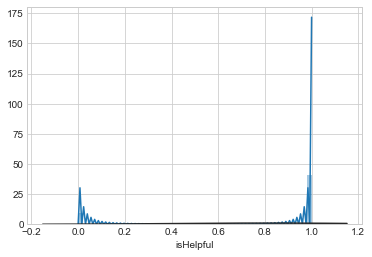

In [27]:
from scipy.stats import norm, skew

# Lets explore the distribution of the helpfulness target variable
sns.distplot(dataset['isHelpful'], fit=norm)

##### Custom Feature Extraction 

In [28]:
# This utility will generate the difference between the first review and the corresponding review days difference.
def getReviewTimeDifferenceFromMin(dataset):
    dataset['reviewTime'] = pd.to_datetime(dataset['reviewTime'])
    dataset['firstReviewTime'] = dataset.groupby(['asin'])['reviewTime'].transform(min)
    dataset['review_first_diff'] = (dataset['reviewTime'] - dataset['firstReviewTime']).astype('timedelta64[D]')
    dataset = dataset.drop(columns = ['firstReviewTime', 'reviewTime'])
    
    return dataset

In [29]:
# This utility will count the sentences in the review text
def countReviewSentence(dataset):
    pun_sen = ['.', '!', '?']
    text_col = dataset['reviewText']
    sentence_counts = []
    for i in text_col:
        sentence_count = []
        for j in pun_sen:
            count_a = i.count(j)
            sentence_count.append(count_a)
        sentence_counts.append(sum(sentence_count))
    dataset['reviewSentencesCount'] = sentence_counts
    return dataset

In [30]:
# This utiity will generate the no of characters present in review text.
# This will be used in determining the readability of each review
punctuation = ['!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~','``',"''",'--']
def count_characters(dataset):
    reviewcharacters = []
    text_col = dataset['reviewText']
    for i in text_col:
        a = dict(Counter(i))
        b = {k:v for k, v in a.items() if k not in punctuation}
        c = sum(list(b.values()))
        reviewcharacters.append(c)
    dataset['reviewChars'] = reviewcharacters
    return dataset

In [31]:
# Readability of each review (ARI as index to measure)
def readability(dataset):
    wordperSen = []
    charperWord = []
    reviewRead = []
    len_df = len(dataset)
    dataset['reviewTextWordCount'] = dataset['reviewText'].apply(lambda x: len(x.split()))
    a = list(dataset['reviewTextWordCount'])
    b = list(dataset['reviewSentencesCount'])
    c = list(dataset['reviewChars'])
    for i in range(len_df):
        if b[i] == 0:
            wordperSen.append(0)
        else:
            j = a[i] / b[i]
            wordperSen.append(j)
        if a[i] == 0:
            charperWord.append(0)
        else:
            l = c[i] / a[i]
            charperWord.append(l)
        ari = 4.71 * charperWord[i] + 0.5 * wordperSen[i] - 21.43
        reviewRead.append(ari)
    dataset['reviewReadability'] = reviewRead
    return dataset

In [32]:
# drop extra features in the dataset
def drop_extra_features(dataset):
    dataset = dataset.drop(columns = ['asin', 'reviewerName', 'reviewerID','summary','unixReviewTime', 'reviewTextWordCount','overall',  'reviewSentencesCount', 'reviewChars'], axis = 1)
    
    return dataset

In [33]:
# This function will get all the customised features
def getCustomFeatures(dataset):
    start = time.time()
    
    dataset = getReviewTimeDifferenceFromMin(dataset)
    dataset = countReviewSentence(dataset)
    dataset = count_characters(dataset)
    dataset = readability(dataset)
    dataset = drop_extra_features(dataset)
    
    end = time.time()
    print('Total time to derive the custom features {:4f} seconds'.format(end - start))
    return dataset

##### Defining Text Normalizer 

In [34]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

contraction_dict = {"aint": "is not", "arent": "are not","cant": "cannot", "'cause": "because", "couldve": "could have", "couldnt": "could not", "didnt": "did not",  "doesnt": "does not", "dont": "do not", "hadnt": "had not", "hasnt": "has not", "havent": "have not", "wasnt": "was not", "isnt": "is not", "shouldnt": "should not", "thats": "that is"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Misspelling corrections
mispell_dict = {"complis": "complies", "wellmade": "well-made", "onoff": "on/off", "kitchenaid": "kitchemaid", "roomba": "room", "appare": "apparel", "bodrum": "bodrum", "notly": "hotly", "kcup": "cup", "kcups": "cups", "krups": "cups", "roomthe":"room the"}
def _get_mispell(contraction_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_mispell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_text(text):
    # lower case and remove special characters\whitespaces
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    text = clean_text(text)
    text = replace_contractions(text)
    text = replace_typical_mispell(text)
    # tokenize document
    tokens = wpt.tokenize(text)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    text = ' '.join(filtered_tokens)
    return text

In [35]:
#def get_normalize_text_data(run='train'):
def get_normalize_text_data(dataset):
    start = time.time()
    dataset['normalize_review_text'] = dataset['reviewText'].apply(lambda x: normalize_text(x))
    dataset = dataset.drop(columns=['reviewText'])
    end = time.time()
    
    print('Total time to normalize the text data {:4f} seconds'.format(end - start))
    return dataset

##### Feature Aggregation

In [36]:
# Generate the custom features
dataset = getCustomFeatures(dataset)
# Generate the normalize text feature
dataset = get_normalize_text_data(dataset)
dataset.head(1)

Total time to derive the custom features 10.323085 seconds
Total time to normalize the text data 27.680471 seconds


,isHelpful,review_first_diff,reviewReadability,normalize_review_text
0,1,640.0,12.653924,shortage pop recipes available free web purcha...


##### Train-Test Split Data 

In [37]:
from sklearn.model_selection import train_test_split

X = dataset[['review_first_diff', 'reviewReadability', 'normalize_review_text']]
y = dataset['isHelpful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18363 entries, 8909 to 23654
Data columns (total 3 columns):
review_first_diff        18363 non-null float64
reviewReadability        18363 non-null float64
normalize_review_text    18363 non-null object
dtypes: float64(2), object(1)
memory usage: 573.8+ KB


##### Feature Union and Function Transformer 

In [38]:
from sklearn.base import TransformerMixin

class ColumnExtractor(TransformerMixin):

    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xcols = X[self.cols]
        return Xcols

In [39]:
class TextTFIDFVectorizer(TransformerMixin):
    
    def __init__(self):
        self.vec = None

    def fit(self, X, y=None):
        # stateless transformer
        self.vec =TfidfVectorizer(min_df=0.01, max_df=1., ngram_range=(1, 1))
        self.vec.fit(X['normalize_review_text'])
        return self
    
    def transform(self, X):
        # assumes X is a DataFrame
        # Defining the Tfidf vectorizer
        #vectorizer = TfidfVectorizer(min_df=0.01, max_df=1., ngram_range=(1, 1))
        #fit the vectorizers to the data.
        features = self.vec.transform(X['normalize_review_text'])
    
        return features
        

In [40]:
class TextWord2Vectorizer(TransformerMixin):
    def __init__(self):
        self.word2vec = None
        
    def _col_transform(self, words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,),dtype="float64")
        nwords = 0.
    
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])

        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        wpt = nltk.WordPunctTokenizer()
        tokenized_corpus = [wpt.tokenize(document) for document in X['normalize_review_text']] 
        
        # Set values for various parameters
        feature_size = 100    # Word vector dimensionality  
        window_context = 5    # Context window size                                                                                    
        min_word_count = 2    # Minimum word count                        
        sample = 1e-3         # Downsample setting for frequent words

        self.word2vec = Word2Vec(tokenized_corpus, size=feature_size, 
                                      window=window_context, min_count = min_word_count,
                                      sample=sample, iter=10)
        
        vocabulary = set(self.word2vec.wv.index2word)
        features = [self._col_transform(tokenized_sentence, self.word2vec, vocabulary, num_features=100)
                    for tokenized_sentence in tokenized_corpus]
        return np.array(features)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [41]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


NUM_FEATURES = ['review_first_diff', 'reviewReadability']
TEXT_FEATURE = ['normalize_review_text']

process_and_join_features_tfidf = FeatureUnion(
                            transformer_list=[
                                ('numeric_feaures', Pipeline([
                                    ('selector', ColumnExtractor(NUM_FEATURES)), 
                                    ('scale', StandardScaler())
                                ])),
                                ('text_features', Pipeline([
                                    ('selector', ColumnExtractor(TEXT_FEATURE)),
                                    ('vectorizer',TextTFIDFVectorizer())
                                ]))
                            ])


process_and_join_features_word2vec = FeatureUnion(
                            transformer_list=[
                                ('numeric_feaures', Pipeline([
                                    ('selector', ColumnExtractor(NUM_FEATURES)), 
                                    ('scale', StandardScaler())
                                ])),
                                ('text_features', Pipeline([
                                    ('selector', ColumnExtractor(TEXT_FEATURE)),
                                    ('vectorizer',TextWord2Vectorizer())
                                ]))
                            ])

pipe_lr_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_dt_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', DecisionTreeClassifier(random_state=42))
                ])
pipe_randomforest_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', RandomForestClassifier(random_state=42))
                ])
pipe_adaboost_tfidf = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('clf', AdaBoostClassifier(random_state=42))
                ])

pipe_lr_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_dt_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', DecisionTreeClassifier(random_state=42))
                ])
pipe_randomforest_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', RandomForestClassifier(random_state=42))
                ])
pipe_adaboost_word2vec = Pipeline([
                   ('union', process_and_join_features_word2vec),
                   ('clf', AdaBoostClassifier(random_state=42))
                ])


#### Select Base Model 

In [42]:
from sklearn.metrics import roc_auc_score

def train_predict_pipeline(pipeline):
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    #Evaluate model
    p_pred_test = pipeline.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, p_pred_test)
    end = time.time()
    print('Test set accuracy score: %.3f ' % auc_test)
    
clf_pipeline = [pipe_lr_tfidf, pipe_dt_tfidf, pipe_randomforest_tfidf, pipe_adaboost_tfidf, pipe_lr_word2vec, pipe_dt_word2vec,
                pipe_randomforest_word2vec, pipe_adaboost_word2vec]
clf_dict = {0: 'TF-IDF Logistic Regression', 1: 'TF-IDF Decision Tree', 2: 'TF-IDF Random Forest', 3: 'TF-IDF Adaboost', 4: 'Word2Vec Logistic Regression',
             5: 'Word2Vec Decision Tree', 6: 'Word2Vec Random Forest', 7: 'Word2Vec Adaboost'}

In [43]:
for idx, clf_pipe in enumerate(clf_pipeline):
    print('Predicting test accuracy using : %s' % clf_dict[idx])
    start = time.time()
    train_predict_pipeline(clf_pipe)    
    end = time.time()
    
    print('Total time to train and predict : {} is {:4f} seconds'.format(clf_dict[idx], (end-start)))

Predicting test accuracy using : TF-IDF Logistic Regression
Test set accuracy score: 0.748 
Total time to train and predict : TF-IDF Logistic Regression is 11.997715 seconds
Predicting test accuracy using : TF-IDF Decision Tree
Test set accuracy score: 0.555 
Total time to train and predict : TF-IDF Decision Tree is 38.306320 seconds
Predicting test accuracy using : TF-IDF Random Forest
Test set accuracy score: 0.704 
Total time to train and predict : TF-IDF Random Forest is 70.805239 seconds
Predicting test accuracy using : TF-IDF Adaboost
Test set accuracy score: 0.702 
Total time to train and predict : TF-IDF Adaboost is 25.498657 seconds
Predicting test accuracy using : Word2Vec Logistic Regression
Test set accuracy score: 0.675 
Total time to train and predict : Word2Vec Logistic Regression is 139.980813 seconds
Predicting test accuracy using : Word2Vec Decision Tree
Test set accuracy score: 0.536 
Total time to train and predict : Word2Vec Decision Tree is 148.810178 seconds
Pred

Based on the above test accuracy test, TFIDF Logistic Regression has performed better than rest all models.
So in the next step, we will try to optimize the test accuracy by Cross-validation using GridSearchCV

In [44]:
from sklearn.metrics import accuracy_score,precision_score,classification_report

def perform_model_optimization(grids, grid_dict):
    # Fit the grid search objects
    print('Performing model optimizations...')
    best_acc = 0.0
    best_clf = 0
    best_gs = ''
    for idx, gs in enumerate(grids):
        start = time.time()
        print('\nEstimator: %s' % grid_dict[idx])
        # Fit grid search
        gs.fit(X_train, y_train)
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        # Predict on test data with best params
        y_pred = gs.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set precision score for best params: %.3f ' % precision_score(y_test, y_pred))
        print('Classification report :')
        print(classification_report(y_test, y_pred))
        # Track best (highest test accuracy) model
        if precision_score(y_test, y_pred) > best_acc:
            best_acc = precision_score(y_test, y_pred)
            best_gs = gs
            best_clf = idx
        end= time.time()
        print('Total time to perform model optimization {} : {:4f}'.format(grid_dict[idx], (end - start)))
    print('\nClassifier with best test set precision: %s' % grid_dict[best_clf])
    return (best_clf,best_gs)

In [45]:
from sklearn.model_selection import GridSearchCV

# Set grid search params
param_range = [2, 4, 6, 8, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}]
grid_params_dt=[{'clf__min_samples_split' : param_range[1:],
                 'clf__max_depth': param_range}]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_adaboost = [{'clf__learning_rate': [0.01,0.05,0.1,0.3,1],
        'clf__n_estimators': [50, 100]}]


In [46]:
jobs = -1

gs_lr_tfidf = GridSearchCV(estimator=pipe_lr_tfidf,
                     param_grid=grid_params_lr,
                     scoring='precision',cv=5)

gs_dt_tfidf = GridSearchCV(estimator=pipe_dt_tfidf,
                    param_grid=grid_params_dt,
                    scoring='precision',
                    cv=5, n_jobs=jobs)
gs_rf_tfidf = GridSearchCV(estimator=pipe_randomforest_tfidf,
                    param_grid=grid_params_rf,
                    scoring='precision',
                    cv=5, n_jobs=jobs)
gs_adaboost_tfidf = GridSearchCV(estimator=pipe_adaboost_tfidf,
                    param_grid=grid_params_adaboost,
                    scoring='precision',
                    cv=5, n_jobs=jobs)

In [47]:
# List of pipelines for ease of iteration
grids = [gs_lr_tfidf, gs_dt_tfidf, gs_rf_tfidf, gs_adaboost_tfidf]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'TF-IDF Logistic Regression', 1: 'TF-IDF Decision Tree', 2: 'TF-IDF RandomForest', 3: 'TF-IDF Adaboost'}


In [48]:
perform_model_optimization(grids, grid_dict)

Performing model optimizations...

Estimator: TF-IDF Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.829
Test set precision score for best params: 0.834 
Classification report :
              precision    recall  f1-score   support

           0       0.60      0.16      0.25      1694
           1       0.83      0.98      0.90      7351

    accuracy                           0.82      9045
   macro avg       0.72      0.57      0.57      9045
weighted avg       0.79      0.82      0.78      9045

Total time to perform model optimization TF-IDF Logistic Regression : 195.247039

Estimator: TF-IDF Decision Tree
Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 4}
Best training accuracy: 0.817
Test set precision score for best params: 0.821 
Classification report :
              precision    recall  f1-score   support

           0       0.39      0.08      0.13      1694
           1       0.82    

(0, GridSearchCV(cv=5, error_score=nan,
              estimator=Pipeline(memory=None,
                                 steps=[('union',
                                         FeatureUnion(n_jobs=None,
                                                      transformer_list=[('numeric_feaures',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('selector',
                                                                                          <__main__.ColumnExtractor object at 0x00000269D9136588>),
                                                                                         ('scale',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                        

Based on the classification report printed above, though we have high precision or accuracy of about 80%,still its not properly build as the ratio of helpfulness and not helpfulness data is skewed with high number of helpfulness label data  compared to not helpful data. In this case we will perform over-sampling of minority data(not helpful data) so that the data distribution is symmetric using SMOTE. We will select TF-IDF Logistic Regression and Adaboost Classifier as this 2 model performed quite good and percision is almost close to each other

In [49]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

pipe_lr_tfidf_random_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', RandomOverSampler(random_state=777)),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_lr_tfidf_smote_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', SMOTE(random_state=777)),
                   ('clf', LogisticRegression(random_state=42))
                ])
pipe_adaboost_tfidf_random_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', RandomOverSampler(random_state=777)),
                   ('clf', AdaBoostClassifier(random_state=42))
                ])
pipe_adaboost_tfidf_smote_sampling = Pipeline([
                   ('union', process_and_join_features_tfidf),
                   ('random_sampling', SMOTE(random_state=777)),
                   ('clf', AdaBoostClassifier(random_state=42))
                ])

In [50]:
gs_lr_tfidf_random_sampling = GridSearchCV(estimator=pipe_lr_tfidf_random_sampling,
                     param_grid=grid_params_lr,
                     scoring='accuracy',cv=5)
gs_lr_tfidf_smote_sampling = GridSearchCV(estimator=pipe_lr_tfidf_smote_sampling,
                     param_grid=grid_params_lr,
                     scoring='accuracy',cv=5)
gs_adaboost_tfidf_random_sampling = GridSearchCV(estimator=pipe_adaboost_tfidf_random_sampling,
                     param_grid=grid_params_adaboost,
                     scoring='accuracy',cv=5)
gs_adaboost_tfidf_smote_sampling = GridSearchCV(estimator=pipe_adaboost_tfidf_smote_sampling,
                     param_grid=grid_params_adaboost,
                     scoring='accuracy',cv=5)

In [51]:
# List of pipelines for ease of iteration
grids_sampling = [gs_lr_tfidf_random_sampling, gs_lr_tfidf_smote_sampling, gs_adaboost_tfidf_random_sampling, gs_adaboost_tfidf_smote_sampling]

# Dictionary of pipelines and classifier types for ease of reference
grid_sampling_dict = {0: 'Random Oversampling TF-IDF Logistic Regression', 1: 'SMOTE Oversampling TF-IDF Logistic Regression',
                     2: 'Random Oversampling TF-IDF Adaboost Classifier', 3: 'SMOTE Oversampling TF-IDF Adaboost Classifier'}


In [52]:
best_clf,best_gs = perform_model_optimization(grids_sampling, grid_sampling_dict)

Performing model optimizations...

Estimator: Random Oversampling TF-IDF Logistic Regression
Best params: {'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.710
Test set precision score for best params: 0.896 
Classification report :
              precision    recall  f1-score   support

           0       0.34      0.64      0.45      1694
           1       0.90      0.72      0.80      7351

    accuracy                           0.70      9045
   macro avg       0.62      0.68      0.62      9045
weighted avg       0.79      0.70      0.73      9045

Total time to perform model optimization Random Oversampling TF-IDF Logistic Regression : 205.302248

Estimator: SMOTE Oversampling TF-IDF Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.706
Test set precision score for best params: 0.901 
Classification report :
              precision    recall  f1-score   support

  

In [53]:
from sklearn.externals import joblib
# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_sampling_dict[best_clf], dump_file))


Saved SMOTE Oversampling TF-IDF Logistic Regression grid search pipeline to file: best_gs_pipeline.pkl


Based on the our analysis, using SMOTE Oversampling TFIDF Logistic Regression, we got the highest precision of around 90%.